# Melt, Weather --> LSTM --> streamflow

In [1]:
#first: are you working in colab?
colab = 1

if colab:
    
    #mount drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    dataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'
    
else:
    
    dataPath = ''


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#import required libraries

import pandas as pd
import numpy as np
#from netCDF4 import Dataset
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
import keras
import pickle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#define NSE

def nse(y_obs, y_model):

  """
  nse = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x1) where N is the number of observations in time
  """

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))
  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2)
  return nse

# Load data and pre-process

In [0]:
#M = pd.read_csv(dataPath + 'stationGlacierMelt.csv',header=None)
M = pd.read_csv(dataPath + 'stationGlacierRunoff.csv',header=None)

pickle_in = open(dataPath + 'flowDict.pickle','rb')
flowDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'tempDict.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'precDict.pickle','rb')
precDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'relHDict.pickle','rb')
relHDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'ssrdDict.pickle','rb')
ssrdDict = pickle.load(pickle_in)

#unpack data

stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flowwindow_norm_NF'] #normalized discharge with nans filled (NF)
T = tempDict['T']
P = precDict['P']
H = relHDict['H']
S = ssrdDict['S']

In [0]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))
T = np.asarray(T[indStartERA:])
P = np.asarray(P[indStartERA:])
H = np.asarray(H[indStartERA:])
S = np.asarray(S[indStartERA:])
M = np.asarray(M.iloc[:,indStartERA:])

##just alberta
#T = T[:,:15,29:]
#P = P[:,:15,29:]
#H = H[:,:15,28:]
#S = S[:,:15,28:]

flowDays = flowDays[indStartFlow:]
flowMonths = flowMonths[indStartFlow:]
flowYears = flowYears[indStartFlow:]

eraDays = eraDays[indStartERA:]
eraMonths = eraMonths[indStartERA:]
eraYears = eraYears[indStartERA:]

In [0]:
#loop through stations and find the closest era grid cell

stationT = np.empty((len(stationLat),len(eraDays)))
stationP = np.empty((len(stationLat),len(eraDays)))
stationH = np.empty((len(stationLat),len(eraDays)))
stationS = np.empty((len(stationLat),len(eraDays)))
stationM = np.empty((len(stationLat),len(eraDays)))

for kk in range(len(stationLat)): #for each station
    
    dlat = np.min(np.abs(stationLat[kk] - eraLat))
    indLat = np.argwhere(np.abs(stationLat[kk] - eraLat) == dlat)[0]
    dlon = np.min(np.abs(stationLon[kk] - eraLon))
    indLon = np.argwhere(np.abs(stationLon[kk] - eraLon) == dlon)[0]
    
    stationT[kk] = np.squeeze(T[:,indLat,indLon])
    stationP[kk] = np.squeeze(P[:,indLat,indLon])
    stationH[kk] = np.squeeze(H[:,indLat,indLon])
    stationS[kk] = np.squeeze(S[:,indLat,indLon])
    stationM[kk] = np.squeeze(M[kk])
    
#use only stations with glaciers
stationsWithGlaciers = np.squeeze(np.argwhere(np.sum(stationM,axis=1)>0))
stationT = stationT[stationsWithGlaciers,:]
stationP = stationP[stationsWithGlaciers,:]
stationH = stationH[stationsWithGlaciers,:]
stationS = stationS[stationsWithGlaciers,:]
stationM = stationM[stationsWithGlaciers,:]
F = F[:,stationsWithGlaciers]

#normalize
stationT = (stationT - np.mean(stationT))/np.std(stationT)
stationP = (stationP - np.mean(stationP))/np.std(stationP)
stationH = (stationH - np.mean(stationH))/np.std(stationH)
stationS = (stationS - np.mean(stationS))/np.std(stationS)
stationM = (stationM - np.mean(stationM))/np.std(stationM)


In [0]:
#normalize flow to be between 0 and 1

for station in range(np.shape(F)[1]):
    #F[:,station] = (F[:,station] - np.mean(F[:,station]))/np.std(F[:,station])
    minF = np.min(F[:,station])
    maxF = 2 * np.std(F[:,station])
    F[:,station] = (F[:,station] - minF) / (maxF - minF)
    
    for inds in np.argwhere(F>4):
      F[inds[0],inds[1]] = 4
  

In [0]:
#create input/output datasets

num_stations = 5

num_obs = (len(eraDays) - 365) * num_stations #len(stationsWithGlaciers)

x = np.empty((num_obs,365,5))
y = np.empty((num_obs))

jj = 0

for station in range(num_stations): #range(len(stationsWithGlaciers)): #for each station
    
    for day in range(len(eraDays)-365): #for each day of flow
        
        x[jj,:,0] = stationT[station,day:day+365]
        x[jj,:,1] = stationP[station,day:day+365]
        x[jj,:,2] = stationH[station,day:day+365]
        x[jj,:,3] = stationS[station,day:day+365]
        x[jj,:,4] = stationM[station,day:day+365]
        y[jj] = F[day+365,station]
        jj+=1
    

In [47]:
num_obs/num_stations

8401.0

In [0]:
#split into train/test

#trainSplit = 'fraction' #define fraction of data to have as train/test
#trainSplit = 'LOSO' #leave one station out
trainSplit = 'LOYO' #leave one year out

if trainSplit == 'fraction': 

  fracTrain = 0.8
  Ntrain = int(fracTrain * len(x))

  x_train = x[:Ntrain]
  y_train = y[:Ntrain]

  x_test = x[Ntrain:]
  y_test = y[Ntrain:]

elif trainSplit == 'LOSO':

  Ntrain = (len(eraDays) - 365) * (num_stations - 1)

  x_train = x[:Ntrain]
  y_train = y[:Ntrain]

  x_test = x[Ntrain:]
  y_test = y[Ntrain:]

elif trainSplit == 'LOYO':

  obs_per_station = int(len(x) / num_stations)
  Ntest_per_station = 730
  Ntrain_per_station = int(obs_per_station - Ntest_per_station)

  x_train = np.empty((Ntrain_per_station * num_stations,365,5))
  y_train = np.empty((Ntrain_per_station * num_stations))

  x_test = np.empty((Ntest_per_station * num_stations,365,5))
  y_test = np.empty((Ntest_per_station * num_stations))

  kk = 0
  jj = 0
  ii = 0
  for station in range(num_stations):

    x_train_station = x[kk : kk+Ntrain_per_station]
    y_train_station = y[kk : kk+Ntrain_per_station]

    x_test_station = x[kk+Ntrain_per_station : kk+obs_per_station]
    y_test_station = y[kk+Ntrain_per_station : kk+obs_per_station]

    x_train[jj : jj+Ntrain_per_station] = x_train_station
    y_train[jj : jj+Ntrain_per_station] = y_train_station

    x_test[ii : ii+Ntest_per_station] = x_test_station
    y_test[ii : ii+Ntest_per_station] = y_test_station

    kk += obs_per_station
    jj += Ntrain_per_station
    ii += Ntest_per_station


In [70]:
len(y_train) + len(y_test)

42005

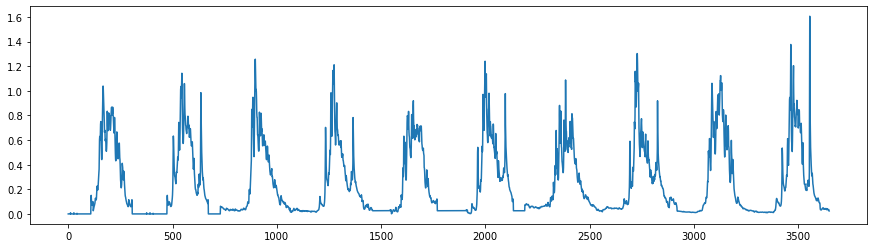

In [82]:
plt.figure(figsize=(15,4))
plt.plot(y_test)


In [83]:
#build model

model = Sequential()
model.add(LSTM(20, 
               input_shape = (365,5), 
               return_sequences = True,
               #return_state = True,
               kernel_regularizer = regularizers.l2(0.001)))
model.add(Dropout(rate = 0.1))
model.add(LSTM(20, 
               input_shape = (365,5), 
               return_sequences = True,
               #return_state = True,
               kernel_regularizer = regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(1,
                activation = 'linear'))
model.compile(loss = 'mse', 
              optimizer=keras.optimizers.Adam(lr=0.005))
model.summary()

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience = 5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 365, 20)           2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 365, 20)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 365, 20)           3280      
_________________________________________________________________
flatten_2 (Flatten)          (None, 7300)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7301      
Total params: 12,661
Trainable params: 12,661
Non-trainable params: 0
_________________________________________________________________


In [84]:
#train model

batch_size = 2048
epochs = 10
history = model.fit(x_train,y_train, 
                    validation_split = 0.2,
                    shuffle = True, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    verbose = 1, 
                    callbacks = [es])

Train on 30684 samples, validate on 7671 samples
Epoch 1/10
30684/30684 [==============================] - 29s 947us/step - loss: 0.2422 - val_loss: 0.1199
Epoch 2/10
30684/30684 [==============================] - 27s 867us/step - loss: 0.0758 - val_loss: 0.0621
Epoch 3/10
30684/30684 [==============================] - 26s 860us/step - loss: 0.0560 - val_loss: 0.0541
Epoch 4/10
30684/30684 [==============================] - 27s 869us/step - loss: 0.0483 - val_loss: 0.0484
Epoch 5/10
30684/30684 [==============================] - 26s 860us/step - loss: 0.0435 - val_loss: 0.0455
Epoch 6/10
30684/30684 [==============================] - 27s 864us/step - loss: 0.0405 - val_loss: 0.0442
Epoch 7/10
30684/30684 [==============================] - 26s 854us/step - loss: 0.0382 - val_loss: 0.0411
Epoch 8/10
30684/30684 [==============================] - 26s 852us/step - loss: 0.0362 - val_loss: 0.0408
Epoch 9/10
30684/30684 [==============================] - 26s 854us/step - loss: 0.0350 - val_l

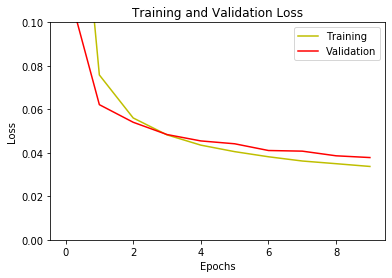

In [86]:
saveIt = 0

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(loss, 'y', label='Training')
plt.plot(val_loss, 'r', label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.xlim((1,10))
#plt.ylim((0,.1))
#plt.show()

if saveIt:
  plt.savefig('loss.png')

In [0]:
#predict streamflow with trained model
#y_trainPredict = model.predict(x_train)
y_testPredict = model.predict(x_test)

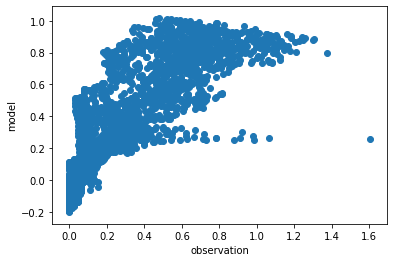

In [88]:
#visualize

saveIt = 0

plt.scatter(y_test,y_testPredict)
plt.xlabel('observation')
plt.ylabel('model')

if saveIt:
  plt.savefig('obs_vs_model.png')

In [89]:
#compute NSE

NSE = nse(y_test,y_testPredict)
print('NSE = ' + str(NSE)[:4])

NSE = 0.62


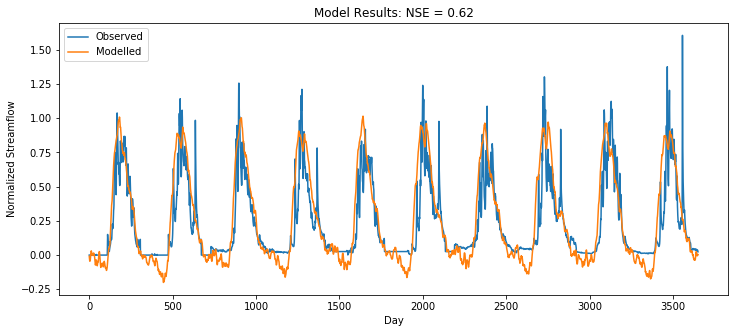

In [91]:
#visualize more

saveIt = 0

plt.figure(figsize = (12,5))
plt.plot(y_test, label = 'Observed')
plt.plot(y_testPredict, label = 'Modelled')
#plt.xlim((4500,6000))
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.title('Model Results: NSE = ' + str(NSE)[:4])
#plt.show()

if saveIt:
  plt.savefig('modelled_time_series.png')

# Fine tuning on one station

In [0]:
#create input/output datasets

station_fine_tune = 1

num_obs = (len(eraDays) - 365) * num_stations #len(stationsWithGlaciers)

x = np.empty((num_obs,365,5))
y = np.empty((num_obs))

jj = 0

for station in range(num_stations): #range(len(stationsWithGlaciers)): #for each station
    
    for day in range(len(eraDays)-365): #for each day of flow
        
        x[jj,:,0] = stationT[station_fine_tune,day:day+365]
        x[jj,:,1] = stationP[station_fine_tune,day:day+365]
        x[jj,:,2] = stationH[station_fine_tune,day:day+365]
        x[jj,:,3] = stationS[station_fine_tune,day:day+365]
        x[jj,:,4] = stationM[station_fine_tune,day:day+365]
        y[jj] = F[day+365,station_fine_tune]
        jj+=1

In [0]:
#split into train/test
fracTrain = 0.8
Ntrain = int(fracTrain * len(x))

x_train = x[:Ntrain]
y_train = y[:Ntrain]

x_test = x[Ntrain:]
y_test = y[Ntrain:]

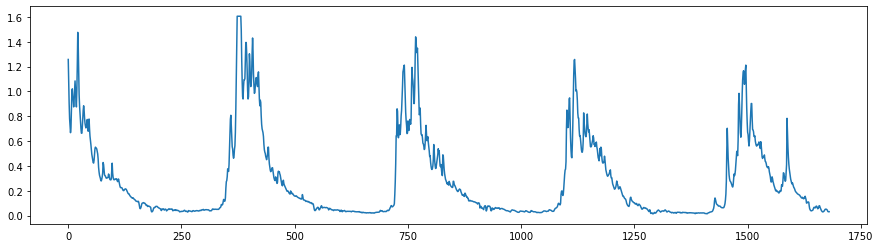

In [121]:
plt.figure(figsize=(15,4))
plt.plot(y_test)

In [122]:
#train model

batch_size = 256
epochs = 10
history = model.fit(x_train,y_train, 
                    validation_split = 0.2, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    verbose = 1, 
                    callbacks = [es])

Train on 5376 samples, validate on 1344 samples
Epoch 1/10
5376/5376 [==============================] - 34s 6ms/step - loss: 0.0237 - val_loss: 0.0337
Epoch 2/10
5376/5376 [==============================] - 35s 6ms/step - loss: 0.0206 - val_loss: 0.0369
Epoch 3/10
5376/5376 [==============================] - 34s 6ms/step - loss: 0.0204 - val_loss: 0.0356
Epoch 4/10
5376/5376 [==============================] - 34s 6ms/step - loss: 0.0187 - val_loss: 0.0337
Epoch 5/10
5376/5376 [==============================] - 34s 6ms/step - loss: 0.0176 - val_loss: 0.0296
Epoch 6/10
5376/5376 [==============================] - 34s 6ms/step - loss: 0.0167 - val_loss: 0.0304
Epoch 7/10
5376/5376 [==============================] - 34s 6ms/step - loss: 0.0167 - val_loss: 0.0286
Epoch 8/10
5376/5376 [==============================] - 34s 6ms/step - loss: 0.0162 - val_loss: 0.0330
Epoch 9/10
5376/5376 [==============================] - 34s 6ms/step - loss: 0.0148 - val_loss: 0.0275
Epoch 10/10
5376/5376 [==

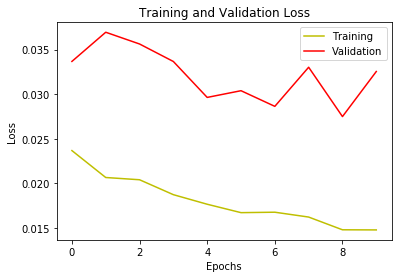

In [123]:
saveIt = 0

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(loss, 'y', label='Training')
plt.plot(val_loss, 'r', label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.ylim((0,1))
#plt.show()

if saveIt:
  plt.savefig('loss.png')

In [0]:
#predict streamflow with trained model
#y_trainPredict = model.predict(x_train)
y_testPredict = model.predict(x_test)

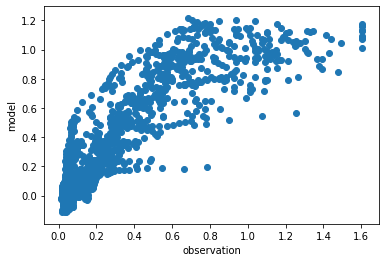

In [125]:
#visualize

saveIt = 0

plt.scatter(y_test,y_testPredict)
plt.xlabel('observation')
plt.ylabel('model')

if saveIt:
  plt.savefig('obs_vs_model.png')

In [126]:
#compute NSE

NSE = nse(y_test,y_testPredict)
print('NSE = ' + str(NSE)[:4])

NSE = 0.70


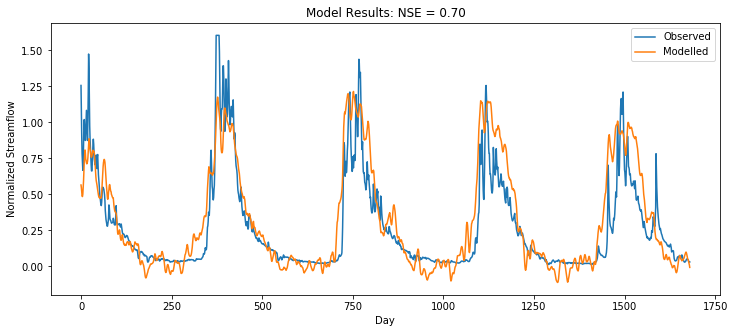

In [127]:
#visualize more

saveIt = 0

plt.figure(figsize = (12,5))
plt.plot(y_test, label = 'Observed')
plt.plot(y_testPredict, label = 'Modelled')
#plt.xlim((4500,6000))
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.title('Model Results: NSE = ' + str(NSE)[:4])
#plt.show()

if saveIt:
  plt.savefig('modelled_time_series.png')

# What is the model learning?

In [0]:
#investigate what the model is looking at in test set

day = 100 #day number in test set to visualize what model is 'thinking' when predicting flow at this day
iters = 1000
fracOnes = 0.9 #fraction to leave unmaksed
nones = int(365*fracOnes)
nzeros = 365 - nones
heat = np.zeros((1,365,5))

xday = np.reshape(x_test[day],(1,365,5))
yday = model.predict(xday)

for iter in range(iters):
  
  #mask = np.hstack((np.ones(nones), np.zeros(nzeros)))
  #np.random.shuffle(mask)
  #mask = np.reshape(mask,(1,365,1))
  #xday_mask = xday*mask
  #yday_mask = model.predict(xday_mask)

  #delta = np.abs(yday - yday_mask)
  #heat += delta * (1 - mask)

  noise = (np.random.rand(1,365,5) - 0.5)/5
  xday_noise = xday + noise
  yday_noise = model.predict(xday_noise)
  
  delta = np.abs(yday - yday_noise)#**2
  heat += delta * np.abs(noise)

  #del noise
  #del xday_noise


  



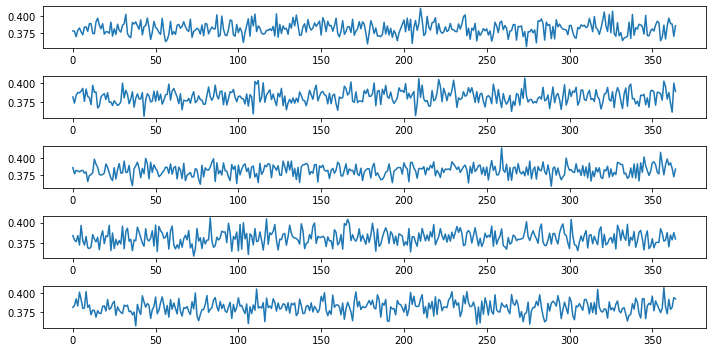

In [204]:
#visualize heatmap

plt.figure(figsize = (10,5))

for var in range(5):
  plt.subplot(5,1,var+1)
  plt.plot(np.squeeze(heat[0,:,var]))

#plt.subplot(111)
#plt.plot(np.squeeze(heat))
#plt.xlabel('Days before flow')
#plt.ylabel('Relative importance')
plt.tight_layout()
plt.show()

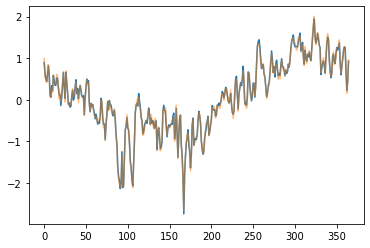

In [195]:
plt.plot(xday[0,:,0])
plt.plot(xday_noise[0,:,0],alpha = 0.5)

In [219]:
import keras.backend as K
statesAll=[]
for layer in model.layers:
  print(layer)
  if getattr(layer,'stateful',False):
    if hasattr(layer,'states'):
      print('hi')
      for state in layer.states:
        statesAll.append(K.get_value(state))

In [221]:
model.layers

In [153]:
np.shape(xday[0,:,0])

(365,)

In [0]:
n = 10
m = 10
a = np.hstack((np.ones(n), np.zeros(m)))
print(np.random.shuffle(a))

None


In [0]:
a = xday*mask

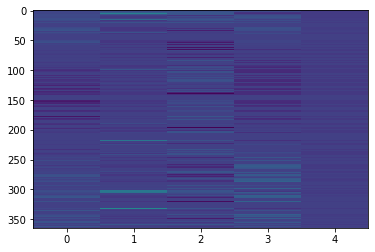

In [0]:
plt.imshow(np.squeeze(a),aspect='auto')

(0, 100)

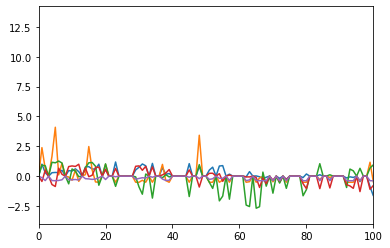

In [0]:
plt.plot(np.sum(a,axis=0))
plt.xlim((0,100))

In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
import scipy
#def create_mask(h = 1, w = 10, H = 5, W = 365, p_1 = 0.7):

h = 2
w = 10
H = 5
W = 365
p_1 = 0.7

mask_small = np.random.choice([0,1], size = (h,w), p = [1-p_1, p_1])
x1 = [val for val in range(w)]
y1 = [val for val in range(h)]
x2 = [val * (w/W) for val in range(W)]
y2 = [val * (h/H) for val in range(H)]
f = scipy.interpolate.interp2d(x1,y1,mask_small,kind = 'linear')
mask_large = f(x2,y2,mask_small)

#return mask_small, mask_large

#mask_small, mask = create_mask()
plt.imshow(mask_large)


ValueError: ignored

In [0]:
mask_large

In [0]:
# create a random mask
def create_mask(h=7, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):

    # create random hxw mask
    mask = np.random.choice([0, 1], size=(h, w), p=[1 - p_1, p_1])

    # resize
    mask = Image.fromarray(mask * 255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # crop to HxW
    w_crop = np.random.randint(0, w + 1)
    h_crop = np.random.randint(0, h + 1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize
    mask /= np.max(mask)

    return mask